## Pruning v/s Quantization in CNNs v/s ViT

Sakshi Mahadik

Jaiwin Shah

Surya Sukumar

### Import libraries + Load dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.quantization
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import timm
import copy
import os
import tempfile
from torch.ao.quantization import get_default_qconfig, prepare, convert
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/ssukuma2/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/ssukuma2/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

Path to dataset files: /home/ssukuma2/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [3]:
# Dataset loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = ImageFolder('../FER2013/train', transform=transform)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = ImageFolder('../FER2013/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check distribution
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 22968
Validation samples: 5741
Test samples: 7178


### Load VIT model

In [4]:
vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=7).to(device)

### Pruning and Quantization methods

In [5]:
# Unstructured Pruning for ViT
def unstructured_prune_vit(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")
    return model

# Structured Attention Head Pruning for ViT
def prune_vit_attention_heads(model, heads_to_prune=2):
    for name, module in model.named_modules():
        if hasattr(module, 'qkv') and hasattr(module, 'num_heads'):
            heads_dim = module.qkv.weight.shape[0] // 3
            head_size = heads_dim // module.num_heads
            qkv_weights = module.qkv.weight.data.view(3, module.num_heads, head_size, -1)
            norms = qkv_weights.norm(dim=(2, 3))
            importance = norms.sum(dim=0)
            prune_indices = torch.topk(importance, heads_to_prune, largest=False).indices
            for i in prune_indices:
                qkv_weights[:, i, :, :] = 0
            module.qkv.weight.data = qkv_weights.view(-1, module.qkv.weight.shape[1])
    return model

In [6]:
def fuse_model_blocks(model):
    torch.quantization.fuse_modules(model, [["conv1", "bn1", "relu"]], inplace=True)
    for module_name, module in model.named_children():
        if "layer" in module_name:
            for block in module:
                torch.quantization.fuse_modules(
                    block, [["conv1", "bn1", "relu"], ["conv2", "bn2"]],
                    inplace=True
                )
                if hasattr(block, "downsample") and isinstance(block.downsample, torch.nn.Sequential):
                    if len(block.downsample) >= 2:
                        torch.quantization.fuse_modules(block.downsample, ["0", "1"], inplace=True)

In [7]:
import torch
import torch.nn as nn
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization.qconfig_mapping import get_default_qconfig_mapping

# --- Custom quantization-safe LayerNorm replacement ---
class QuantLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True):
        super().__init__()
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = tuple(normalized_shape)
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(*self.normalized_shape))
            self.bias = nn.Parameter(torch.zeros(*self.normalized_shape))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        if self.elementwise_affine:
            x = x * self.weight + self.bias
        return x

# --- Main function to quantize a pruned ViT model ---
def quantize_pruned_vit_model(model, calibration_loader, num_batches=10):
    import copy

    # Clone the model to avoid modifying the original
    model = copy.deepcopy(model)
    model.eval().cpu()

    # Replace incompatible modules (GELU, LayerNorm)
    def patch_for_static_quant(model):
        replacements = []

        for name, module in model.named_modules():
            if isinstance(module, nn.GELU):
                replacements.append((name, nn.ReLU()))
            elif isinstance(module, nn.LayerNorm):
                try:
                    qln = QuantLayerNorm(module.normalized_shape, eps=module.eps, elementwise_affine=True)
                    qln.weight.data = module.weight.data.clone()
                    qln.bias.data = module.bias.data.clone()
                    replacements.append((name, qln))
                except Exception as e:
                    print(f"Skipping {name} due to shape mismatch: {e}")

        # Apply replacements safely after iteration
        for name, new_module in replacements:
            parent = model
            parts = name.split(".")
            for part in parts[:-1]:
                parent = getattr(parent, part)
            setattr(parent, parts[-1], new_module)

        return model

    model = patch_for_static_quant(model)

    # Quantization config
    qconfig_mapping = get_default_qconfig_mapping("fbgemm")

    # Get example input for FX tracing
    example_input = next(iter(calibration_loader))[0]

    # Prepare for FX static quantization
    prepared_model = prepare_fx(model, qconfig_mapping, example_inputs=example_input)

    # Calibration loop
    with torch.no_grad():
        for i, (x, _) in enumerate(calibration_loader):
            x = x.to(torch.float32)
            prepared_model(x)
            if i >= num_batches:
                break

    # Convert to quantized model
    quantized_model = convert_fx(prepared_model)
    return quantized_model


In [8]:
from torch.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization.qconfig_mapping import get_default_qconfig_mapping


def quantize_vit(model, calibration_loader, num_batches=10):
    model.eval()
    model.cpu()

    qconfig_mapping = get_default_qconfig_mapping("fbgemm")
    example_input = next(iter(calibration_loader))[0]

    # FX Graph Mode Quantization
    prepared = prepare_fx(model, qconfig_mapping, example_inputs=example_input)

    with torch.no_grad():
        for i, (x, _) in enumerate(calibration_loader):
            prepared(x.to(torch.float32))
            x.to("cpu")
            model(x)
            if i >= num_batches:
                break

    quantized_model = convert_fx(prepared)
    return quantized_model

### Training and Evaluation methods

In [9]:
import time

def train(model, train_loader, val_loader, epochs=10, lr=1e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == y).sum().item()
                total += y.size(0)

        train_loss = running_loss / len(train_loader)
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

In [10]:
def evaluate(model, test_loader, quantization=False):
    model.eval()

    if quantization:
        model = model.to("cpu")  # Quantized models must be on CPU
    else:
        model = model.to("cuda")

    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            if quantization:
                x, y = x.to("cpu"), y.to("cpu")
            else:
                x, y = x.to("cuda"), y.to("cuda")

            outputs = model(x)
            pred = outputs.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy = {accuracy:.2f}%")
    return accuracy

In [11]:
def measure_inference_speed(model, test_loader, quantization=False):
    model.eval()
    
    if quantization:
        device = "cpu"
        
    else:
        device = torch.device("cuda")
    
    model.to(device)
    
    start = time.time()
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            _ = model(x)
    end = time.time()
    latency = (end - start) / len(test_loader)
    print(f"Avg Inference Time per Batch: {latency:.4f} sec")
    return latency

def model_size_mb(model, use_state_dict=True):
    with tempfile.NamedTemporaryFile(delete=False) as f:
        if use_state_dict:
            torch.save(model.state_dict(), f.name)
        else:
            torch.save(model, f.name)
        size_mb = os.path.getsize(f.name) / (1024 * 1024)
    print(f"Model Size ({'state_dict' if use_state_dict else 'full model'}): {size_mb:.2f} MB")
    return size_mb

### Plot methods

#### Accuracy v/s Pruning amount

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for polished look
sns.set(style="whitegrid", context="notebook")

def plot_validation_and_test_accuracy(pruning_amounts, val_accuracies, test_accuracies, pruning_type='structured'):
    """
    Plots validation and test accuracy vs. pruning amount for a specific pruning type.

    Args:
        pruning_amounts (list of float): Amounts of pruning applied (e.g., [0.0, 0.3, 0.5]).
        val_accuracies (list of float): Validation accuracies in percent.
        test_accuracies (list of float): Test accuracies in percent.
        pruning_type (str): 'structured' or 'unstructured' (used in plot title and legend).
    """
    plt.figure(figsize=(8, 5))

    plt.plot(pruning_amounts, val_accuracies, marker='o', label='Validation Accuracy', color='blue', linewidth=2)
    plt.plot(pruning_amounts, test_accuracies, marker='s', label='Test Accuracy', color='green', linewidth=2)

    # Annotate values
    for x, y in zip(pruning_amounts, val_accuracies):
        plt.text(x, y + 0.5, f"{y:.2f}%", ha='center', fontsize=9, color='blue')

    for x, y in zip(pruning_amounts, test_accuracies):
        plt.text(x, y - 1.5, f"{y:.2f}%", ha='center', fontsize=9, color='green')

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title(f"{pruning_type.capitalize()} Pruning: Accuracy vs. Pruning Amount", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(pruning_amounts)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

def plot_accuracy_vs_pruning_grouped(pruning_type, pruning_amount, val_accuracies, test_accuracies):
    """
    Plots validation and test accuracy vs. pruning amount for multiple pruning types
    (e.g., 'baseline', 'structured', 'unstructured') on the same plot.

    Args:
        pruning_type (list of str): Type for each model ('baseline', 'structured', etc.)
        pruning_amount (list of float): Corresponding pruning amount (e.g., [0.0, 0.3, 0.5])
        val_accuracies (list of float): Corresponding validation accuracy in %
        test_accuracies (list of float): Corresponding test accuracy in %
    """
    plt.figure(figsize=(9, 5))

    unique_types = sorted(set(pruning_type))
    for ptype in unique_types:
        xs = [amt for t, amt in zip(pruning_type, pruning_amount) if t == ptype]
        #val_ys = [v for t, v in zip(pruning_type, val_accuracies) if t == ptype]
        test_ys = [v for t, v in zip(pruning_type, test_accuracies) if t == ptype]

        #plt.plot(xs, val_ys, marker='o', linestyle='-', linewidth=2, label=f'{ptype} - Val')
        plt.plot(xs, test_ys, marker='s', linestyle='-', linewidth=2, label=f'{ptype}')

        # Annotate points
        #for x, y in zip(xs, val_ys):
        #    plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)
        
        for x, y in zip(xs, test_ys):
            plt.text(x, y - 1.2, f"{y:.1f}%", ha='center', fontsize=9)

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Validation & Test Accuracy vs. Pruning", fontsize=14)
    plt.legend(title="Model Type")
    plt.xticks(sorted(set(pruning_amount)))
    plt.ylim(50, 100)
    plt.tight_layout()
    plt.show()

#### Flops after pruning

In [16]:
from ptflops import get_model_complexity_info

# FLOPs calculation helper
def get_flops(model, input_res=(3, 224, 224)):
    model.eval()
    macs, params = get_model_complexity_info(model, input_res, as_strings=False,
                                              print_per_layer_stat=False, verbose=False)
    flops = 2 * macs  # Approximate FLOPs: 1 MAC = 2 FLOPs
    return flops / 1e9  # Convert to GFLOPs

ModuleNotFoundError: No module named 'ptflops'

In [17]:
# Count total and non-zero parameters (Conv + Linear)
def compute_sparsity(model):
    total_weights = 0
    nonzero_weights = 0

    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight'):
                total_weights += module.weight.nelement()
                nonzero_weights += torch.count_nonzero(module.weight)

    sparsity = 1 - (nonzero_weights / total_weights)
    return sparsity.item()

In [18]:
def plot_flops_after_pruning(labels, flops_values):
    plt.figure(figsize=(7, 4))
    bars = plt.bar(labels, flops_values, color=['steelblue', 'green', 'orange'])
    plt.title('Estimated Effective FLOPs After Pruning')
    plt.ylabel('FLOPs (GigaFLOPs)')
    plt.ylim(0, max(flops_values) * 1.2)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.01, f'{height:.2f}', ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Inference time accross pruning models

In [19]:
def plot_inference_vs_pruning(pruning_type, pruning_amount, inference_times):
    plt.figure(figsize=(8, 5))
    for ptype in set(pruning_type):
        xs = [amt for t, amt in zip(pruning_type, pruning_amount) if t == ptype]
        ys = [t for t_, t in zip(pruning_type, inference_times) if t_ == ptype]
        plt.plot(xs, ys, marker='o', label=ptype, linewidth=2)

        for x, y in zip(xs, ys):
            plt.text(x, y + 0.001, f"{y:.4f}s", ha='center', fontsize=9)

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Inference Time (s/batch)", fontsize=12)
    plt.title("Inference Time vs. Pruning", fontsize=14)
    plt.legend(title="Model Type")
    plt.xticks([0.0, 0.5])
    plt.tight_layout()
    plt.show()

#### Accuracy v/s Preciison level

In [20]:
def plot_accuracy_vs_precision(precisions, accuracies):
    """
    Plot model accuracy vs. precision level.
    
    Args:
        precisions (List[str]): Precision levels (e.g., ['FP32', 'INT8'])
        accuracies (List[float]): Corresponding accuracies (%)
    """
    plt.figure(figsize=(15, 4))
    plt.plot(precisions, accuracies, marker='o', linewidth=2)
    plt.title("Accuracy vs. Precision Level")
    plt.xlabel("Precision")
    plt.ylabel("Accuracy (%)")
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.5, f"{acc:.2f}%", ha='center')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Inference time accross quantized models

In [21]:
import matplotlib.pyplot as plt

def plot_inference_time(models, times_ms):
    """
    Plot inference time for different models.
    
    Args:
        models (List[str]): Model labels (e.g., ['FP32', 'INT8', 'INT8+Pruned'])
        times_ms (List[float]): Inference times in milliseconds
    """
    plt.figure(figsize=(15, 4))
    plt.plot(models, times_ms, marker='o', linestyle='-', linewidth=2, color='red')
    plt.title("Inference Time Across Models")
    plt.xlabel("Model Type")
    plt.ylabel("Time (ms)")
    for i, t in enumerate(times_ms):
        plt.text(i, t + 0.1, f"{t:.1f} ms", ha='center')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Weight Distribution

In [22]:
import numpy as np

def extract_quantized_weights(model):
    """
    Extract quantized weights (int8) from a quantized model using _packed_params.
    Returns a list of flattened numpy arrays.
    """
    weights = []
    for module in model.modules():
        if isinstance(module, (torch.nn.quantized.Conv2d, torch.nn.quantized.Linear)):
            try:
                qweight, _ = module._packed_params._weight_bias()
                weights.append(qweight.dequantize().cpu().flatten().numpy())
            except Exception as e:
                #print(f"Skipping {module}: {e}")
                pass
    return np.concatenate(weights) if weights else None

def plot_quantized_weight_distribution(model_fp32, model_int8, model_int8_pr_st, model_int8_pr_unst):
    import matplotlib.pyplot as plt
    import numpy as np

    def extract_weights(model):
        weights = []
        for module in model.modules():
            if hasattr(module, "weight") and isinstance(module.weight, torch.Tensor):
                weights.append(module.weight.detach().cpu().flatten().numpy())
        return np.concatenate(weights) if weights else None

    w_fp32 = extract_weights(model_fp32)
    w_int8 = extract_quantized_weights(model_int8)
    w_int8_st = extract_quantized_weights(model_int8_pr_st)
    w_int8_unst = extract_quantized_weights(model_int8_pr_unst)

    if w_fp32 is None and w_int8 is None and w_int8_unst and w_int8_st:
        print("No weights found.")
        return

    plt.figure(figsize=(10, 4))
    if w_fp32 is not None:
        plt.subplot(1, 2, 1)
        plt.hist(w_fp32, bins=100, color='blue', alpha=0.7)
        plt.title("Weight Distribution (FP32)")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")

    if w_int8 is not None:
        plt.subplot(1, 2, 2)
        plt.hist(w_int8, bins=100, color='orange', alpha=0.7)
        plt.title("Weight Distribution (INT8)")
        plt.xlabel("Weight Value")
        
    plt.figure(figsize=(10, 6))
    if w_int8_st is not None:
        plt.subplot(2, 2, 1)
        plt.hist(w_int8_st, bins=100, color='green', alpha=0.7)
        plt.title("Weight Distribution (INT8 + Structured pruning)")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        
    if w_int8_unst is not None:
        plt.subplot(2, 2, 2)
        plt.hist(w_int8_unst, bins=100, color='red', alpha=0.7)
        plt.title("Weight Distribution (INT8 + Unstructured pruning)")
        plt.xlabel("Weight Value")

    plt.tight_layout()
    plt.show()

### Training

#### Training Baseline model

In [ ]:
# === Train baseline ===
print("=== Train baseline ===")
train(vit, train_loader, val_loader, epochs=30)
evaluate(vit, test_loader)
model_size_mb(vit)
measure_inference_speed(vit, test_loader)


=== Train baseline ===
Epoch 1: Train Loss = 1.5956, Val Loss = 1.1874, Val Acc = 54.80%
Epoch 2: Train Loss = 1.0636, Val Loss = 1.0366, Val Acc = 60.37%
Epoch 3: Train Loss = 0.8631, Val Loss = 1.0351, Val Acc = 61.07%
Epoch 4: Train Loss = 0.6970, Val Loss = 1.0352, Val Acc = 62.88%
Epoch 5: Train Loss = 0.5187, Val Loss = 1.0678, Val Acc = 63.63%
Epoch 6: Train Loss = 0.3621, Val Loss = 1.2919, Val Acc = 64.08%
Epoch 7: Train Loss = 0.2450, Val Loss = 1.4523, Val Acc = 63.04%
Epoch 8: Train Loss = 0.1798, Val Loss = 1.5992, Val Acc = 64.14%
Epoch 9: Train Loss = 0.1359, Val Loss = 1.6117, Val Acc = 63.47%
Epoch 10: Train Loss = 0.1145, Val Loss = 1.9165, Val Acc = 64.15%
Epoch 11: Train Loss = 0.1179, Val Loss = 1.8556, Val Acc = 63.06%
Epoch 12: Train Loss = 0.0888, Val Loss = 1.7791, Val Acc = 63.09%
Epoch 13: Train Loss = 0.0824, Val Loss = 1.8246, Val Acc = 63.09%
Epoch 14: Train Loss = 0.0903, Val Loss = 1.9207, Val Acc = 64.26%
Epoch 15: Train Loss = 0.0836, Val Loss = 1.8620

RuntimeError: Parent directory vit_models does not exist.

#### Pruning baseline model + Training (Structured)

In [25]:
torch.save(vit, 'vit_models/vit.pt')

In [ ]:
# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_st_01 = prune_vit_attention_heads(vit, heads_to_prune=1)
train(vit_pruned_st_01, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_st_01, test_loader)
model_size_mb(vit_pruned_st_01)
measure_inference_speed(vit_pruned_st_01, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_st_02 = prune_vit_attention_heads(vit, heads_to_prune=2)
train(vit_pruned_st_02, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_st_02, test_loader)
model_size_mb(vit_pruned_st_02)
measure_inference_speed(vit_pruned_st_02, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_st_03 = prune_vit_attention_heads(vit, heads_to_prune=3)
train(vit_pruned_st_03, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_st_03, test_loader)
model_size_mb(vit_pruned_st_03)
measure_inference_speed(vit_pruned_st_03, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_st_04 = prune_vit_attention_heads(vit, heads_to_prune=4)
train(vit_pruned_st_04, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_st_04, test_loader)
model_size_mb(vit_pruned_st_04)
measure_inference_speed(vit_pruned_st_04, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_st_05 = prune_vit_attention_heads(vit, heads_to_prune=5)
train(vit_pruned_st_05, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_st_05, test_loader)
model_size_mb(vit_pruned_st_05)
measure_inference_speed(vit_pruned_st_05, test_loader)

=== Apply structured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.0654, Val Loss = 2.1142, Val Acc = 63.30%
Epoch 2: Train Loss = 0.0068, Val Loss = 2.5263, Val Acc = 63.87%
Epoch 3: Train Loss = 0.0050, Val Loss = 2.7804, Val Acc = 63.66%
Epoch 4: Train Loss = 0.0047, Val Loss = 2.9556, Val Acc = 63.86%
Epoch 5: Train Loss = 0.0043, Val Loss = 3.1279, Val Acc = 63.86%
Test Accuracy = 63.93%
Model Size (state_dict): 327.37 MB
Avg Inference Time per Batch: 0.8454 sec
=== Apply structured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.0239, Val Loss = 2.9253, Val Acc = 63.40%
Epoch 2: Train Loss = 0.0050, Val Loss = 3.4403, Val Acc = 63.25%


In [ ]:
torch.save(vit_pruned_st_01, 'vit_pruned_st/vit_pruned_st_01.pt')
torch.save(vit_pruned_st_02, 'vit_pruned_st/vit_pruned_st_02.pt')
torch.save(vit_pruned_st_03, 'vit_pruned_st/vit_pruned_st_03.pt')
torch.save(vit_pruned_st_04, 'vit_pruned_st/vit_pruned_st_04.pt')
torch.save(vit_pruned_st_05, 'vit_pruned_st/vit_pruned_st_05.pt')

In [ ]:
val_accuracies_st = []
"""val_acc = evaluate(resnet18_pruned_st_01, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_02, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_03, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_04, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_05, val_loader, quantization=False)
val_accuracies_st.append(val_acc)"""

test_accuracies_st = []
test_acc = evaluate(vit_pruned_st_01, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(vit_pruned_st_02, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(vit_pruned_st_03, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(vit_pruned_st_04, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(vit_pruned_st_05, test_loader, quantization=False)
test_accuracies_st.append(test_acc)

Test Accuracy = 65.35%
Test Accuracy = 64.67%
Test Accuracy = 63.90%
Test Accuracy = 63.35%
Test Accuracy = 61.19%


In [ ]:
inf_speed = []
inf_speed_01 = measure_inference_speed(vit_pruned_st_01, test_loader, quantization=False)
inf_speed.append(inf_speed_01)
inf_speed_02 = measure_inference_speed(vit_pruned_st_02, test_loader, quantization=False)
inf_speed.append(inf_speed_02)
inf_speed_03 = measure_inference_speed(vit_pruned_st_03, test_loader, quantization=False)
inf_speed.append(inf_speed_03)
inf_speed_04 = measure_inference_speed(vit_pruned_st_04, test_loader, quantization=False)
inf_speed.append(inf_speed_04)
inf_speed_05 = measure_inference_speed(vit_pruned_st_05, test_loder, quantization=False)
inf_speed.append(inf_speed_05)

Avg Inference Time per Batch: 0.1152 sec
Avg Inference Time per Batch: 0.1165 sec
Avg Inference Time per Batch: 0.1168 sec
Avg Inference Time per Batch: 0.1177 sec
Avg Inference Time per Batch: 0.1197 sec


#### Pruning baseline model + Training (Unstructured)

In [ ]:
# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_unst_01 = unstructured_prune_vit(vit, amount=0.1)
train(vit_pruned_unst_01, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_unst_01, test_loader)
model_size_mb(vit_pruned_unst_01)
measure_inference_speed(vit_pruned_unst_01, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_unst_02 = unstructured_prune_vit(vit, amount=0.2)
train(vit_pruned_unst_02, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_unst_02, test_loader)
model_size_mb(vit_pruned_unst_02)
measure_inference_speed(vit_pruned_unst_02, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_unst_03 = unstructured_prune_vit(vit, amount=0.3)
train(vit_pruned_unst_03, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_unst_03, test_loader)
model_size_mb(vit_pruned_unst_03)
measure_inference_speed(vit_pruned_unst_03, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_unst_04 = unstructured_prune_vit(vit, amount=0.4)
train(vit_pruned_unst_04, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_unst_04, test_loader)
model_size_mb(vit_pruned_unst_04)
measure_inference_speed(vit_pruned_unst_04, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
vit_pruned_unst_05 = unstructured_prune_vit(vit, amount=0.5)
train(vit_pruned_unst_05, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(vit_pruned_unst_05, test_loader)
model_size_mb(vit_pruned_unst_05)
measure_inference_speed(vit_pruned_unst_05, test_loader)

=== Apply structured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.0062, Val Loss = 1.7758, Val Acc = 65.60%
Epoch 2: Train Loss = 0.0042, Val Loss = 1.7916, Val Acc = 65.62%
Epoch 3: Train Loss = 0.0037, Val Loss = 1.8035, Val Acc = 65.51%
Epoch 4: Train Loss = 0.0036, Val Loss = 1.8111, Val Acc = 65.49%
Epoch 5: Train Loss = 0.0035, Val Loss = 1.8475, Val Acc = 65.74%
Test Accuracy = 66.97%
Model Size (state_dict): 42.73 MB
Avg Inference Time per Batch: 0.1232 sec
=== Apply structured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.0063, Val Loss = 1.7447, Val Acc = 65.39%
Epoch 2: Train Loss = 0.0043, Val Loss = 1.7752, Val Acc = 65.63%
Epoch 3: Train Loss = 0.0039, Val Loss = 1.7896, Val Acc = 65.81%
Epoch 4: Train Loss = 0.0037, Val Loss = 1.8032, Val Acc = 65.82%
Epoch 5: Train Loss = 0.0036, Val Loss = 1.8063, Val Acc = 65.70%
Test Accuracy = 66.75%
Model Size (state_dict): 42.73 MB
Avg Inference Time per Batch: 0.1241 sec
=== Apply structured pruning, then fine-tune =

0.12337917353199647

In [ ]:
torch.save(vit_pruned_unst_01, 'resnet18_pruned_unst/resnet18_pruned_unst_01.pt')
torch.save(vit_pruned_unst_02, 'resnet18_pruned_unst/resnet18_pruned_unst_02.pt')
torch.save(vit_pruned_unst_03, 'resnet18_pruned_unst/resnet18_pruned_unst_03.pt')
torch.save(vit_pruned_unst_04, 'resnet18_pruned_unst/resnet18_pruned_unst_04.pt')
torch.save(vit_pruned_unst_05, 'resnet18_pruned_unst/resnet18_pruned_unst_05.pt')

In [ ]:
val_accuracies_unst = []
"""val_acc = evaluate(resnet18_pruned_unst_01, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_02, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_03, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_04, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_05, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)"""

test_accuracies_unst = []
test_acc = evaluate(vit_pruned_unst_01, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(vit_pruned_unst_02, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(vit_pruned_unst_03, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(vit_pruned_unst_04, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(vit_pruned_unst_05, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)

Test Accuracy = 66.97%
Test Accuracy = 66.75%
Test Accuracy = 66.59%
Test Accuracy = 66.82%
Test Accuracy = 66.58%


In [ ]:
baseline_accuracy = evaluate(vit, test_loader)
baseline_inf_speed = measure_inference_speed(vit, test_loader)

Test Accuracy = 65.85%
Avg Inference Time per Batch: 0.1590 sec


In [35]:
resnet18_pruned_st_01 = torch.load('resnet18_pruned_st/resnet18_pruned_st_01.pt', weights_only=False)
resnet18_pruned_st_02 = torch.load('resnet18_pruned_st/resnet18_pruned_st_02.pt', weights_only=False)
resnet18_pruned_st_03 = torch.load('resnet18_pruned_st/resnet18_pruned_st_03.pt', weights_only=False)
resnet18_pruned_st_04 = torch.load('resnet18_pruned_st/resnet18_pruned_st_04.pt', weights_only=False)
resnet18_pruned_unst_01 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_01.pt', weights_only=False)
resnet18_pruned_unst_02 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_02.pt', weights_only=False)
resnet18_pruned_unst_03 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_03.pt', weights_only=False)
resnet18_pruned_unst_04 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_04.pt', weights_only=False)

#### Plots related to Pruning

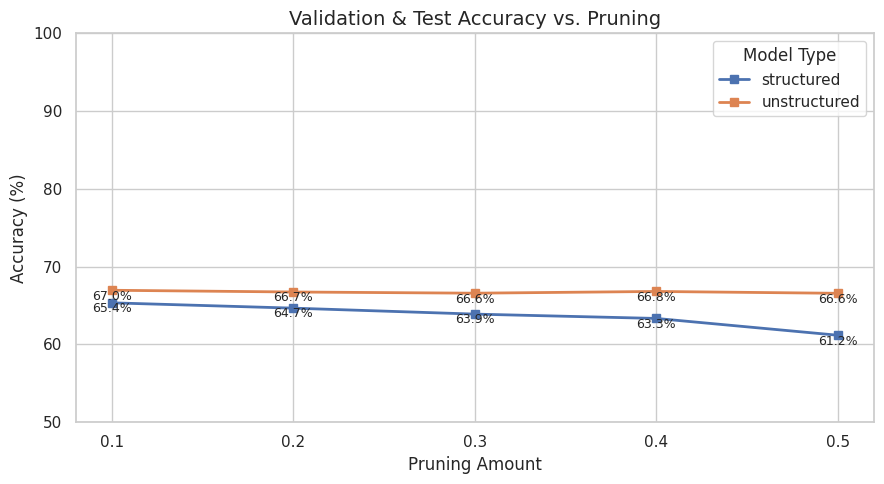

Baseline Accuracy: 65.85399832822513


In [40]:
pruning_amounts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]
pruning_type = ['structured', 'structured', 'structured', 'structured', 'structured', 'unstructured', 'unstructured', 'unstructured', 'unstructured', 'unstructured']
plot_accuracy_vs_pruning_grouped(pruning_type, pruning_amounts, val_accuracies_st + val_accuracies_unst, test_accuracies_st + test_accuracies_unst)
print(f"Baseline Accuracy: {baseline_accuracy}")

In [41]:
inf_speed_un = []
inf_speed_01 = measure_inference_speed(resnet18_pruned_unst_01, test_loader, quantization=False)
inf_speed_un.append(inf_speed_01)
inf_speed_02 = measure_inference_speed(resnet18_pruned_unst_02, test_loader, quantization=False)
inf_speed_un.append(inf_speed_02)
inf_speed_03 = measure_inference_speed(resnet18_pruned_unst_03, test_loader, quantization=False)
inf_speed_un.append(inf_speed_03)
inf_speed_04 = measure_inference_speed(resnet18_pruned_unst_04, test_loader, quantization=False)
inf_speed_un.append(inf_speed_04)
inf_speed_05 = measure_inference_speed(resnet18_pruned_unst_05, test_loader, quantization=False)
inf_speed_un.append(inf_speed_05)

Avg Inference Time per Batch: 0.1244 sec
Avg Inference Time per Batch: 0.1323 sec
Avg Inference Time per Batch: 0.1155 sec
Avg Inference Time per Batch: 0.1595 sec
Avg Inference Time per Batch: 0.1139 sec


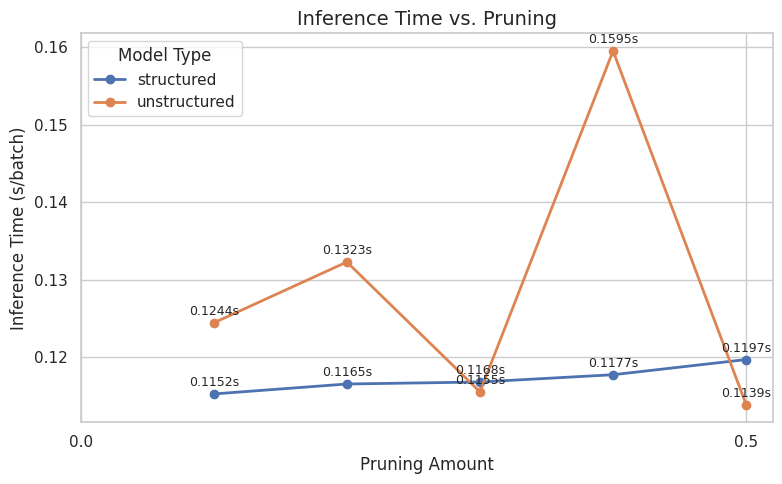

In [42]:
pruning_type = ['structured', 'structured', 'structured', 'structured', 'structured', 'unstructured', 'unstructured', 'unstructured', 'unstructured', 'unstructured']
plot_inference_vs_pruning(pruning_type, pruning_amounts, inf_speed + inf_speed_un)

In [43]:
# Get FLOPs before pruning
flops_before = get_flops(resnet18)

structured_sparsity = compute_sparsity(resnet18_pruned_st_05)
flops_structured_effective = flops_before * (1 - structured_sparsity)

unstructured_sparsity = compute_sparsity(resnet18_pruned_unst_05)
flops_unstructured_effective = flops_before * (1 - unstructured_sparsity)

print(f"FLOPs before pruning: {flops_before:.2f} GFLOPs")
print(f"Structured Pruning: sparsity = {structured_sparsity:.2%}, effective FLOPs = {flops_structured_effective:.2f} GFLOPs")
print(f"Unstructured Pruning: sparsity = {unstructured_sparsity:.2%}, effective FLOPs = {flops_unstructured_effective:.2f} GFLOPs")

FLOPs before pruning: 3.65 GFLOPs
Structured Pruning: sparsity = 37.79%, effective FLOPs = 2.27 GFLOPs
Unstructured Pruning: sparsity = 0.05%, effective FLOPs = 3.65 GFLOPs


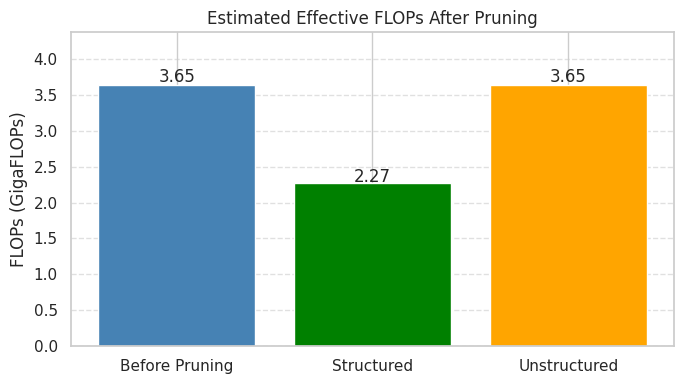

In [44]:
labels = ['Before Pruning', 'Structured', 'Unstructured']
flops_values = [flops_before, flops_structured_effective, flops_unstructured_effective]

plot_flops_after_pruning(labels, flops_values)

#### Quantization

In [20]:
resnet18 = torch.load('resnet18_models/resnet18.pt', weights_only=False)
resnet18_pruned_unst_05 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_05.pt', weights_only=False)
resnet18_pruned_st_05 = torch.load('resnet18_pruned_st/resnet18_pruned_st_05.pt', weights_only=False)

In [21]:
# === Apply quantization on baseline (no pruning) ===
print("=== Apply quantization on baseline (no pruning) ===")
resnet18_quant = quantize_model(resnet18, train_loader)
evaluate(resnet18_quant, test_loader, quantization=True)
model_size_mb(resnet18_quant)
measure_inference_speed(resnet18_quant, test_loader, quantization=True)

# === Apply quantization on pruned model ===
print("=== Apply quantization on pruned model ===")
resnet18_quant_pr_st = quantize_trained_pruned_model(resnet18_pruned_st_05, train_loader)
evaluate(resnet18_quant_pr_st, test_loader, quantization=True)
model_size_mb(resnet18_quant_pr_st)
measure_inference_speed(resnet18_quant_pr_st, test_loader, quantization=True)

print("=== Apply quantization on pruned model ===")
resnet18_quant_pr_unst = quantize_trained_pruned_model(resnet18_pruned_unst_05, train_loader)
evaluate(resnet18_quant_pr_unst, test_loader, quantization=True)
model_size_mb(resnet18_quant_pr_unst)
measure_inference_speed(resnet18_quant_pr_unst, test_loader, quantization=True)

=== Apply quantization on baseline (no pruning) ===


/home/smahadi/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Test Accuracy = 66.17%
Model Size (state_dict): 10.79 MB
Avg Inference Time per Batch: 0.1590 sec
=== Apply quantization on pruned model ===
Test Accuracy = 61.13%
Model Size (state_dict): 10.79 MB
Avg Inference Time per Batch: 0.1757 sec
=== Apply quantization on pruned model ===
Test Accuracy = 65.97%
Model Size (state_dict): 10.79 MB
Avg Inference Time per Batch: 0.1732 sec


0.17317997459816722

In [42]:
torch.save(resnet18_quant, 'resnet18_quantization/resnet18_quant.pt')
torch.save(resnet18_quant_pr_st, 'resnet18_quantization/resnet18_quant_pr_st.pt')
torch.save(resnet18_quant_pr_unst, 'resnet18_quantization/resnet18_quant_pr_unst.pt')

In [22]:
accuracies = []
accuracy_baseline = evaluate(resnet18, test_loader, quantization=True)
accuracy_quant = evaluate(resnet18_quant, test_loader, quantization=True)
accuracy_quant_pr_st = evaluate(resnet18_quant_pr_st, test_loader, quantization=True)
accuracy_quant_pr_unst = evaluate(resnet18_quant_pr_unst, test_loader, quantization=True)
accuracies.append(accuracy_baseline)
accuracies.append(accuracy_quant)
accuracies.append(accuracy_quant_pr_st)
accuracies.append(accuracy_quant_pr_unst)

Test Accuracy = 65.85%
Test Accuracy = 66.17%
Test Accuracy = 61.13%
Test Accuracy = 65.97%


In [23]:
inf_speeds_quantization = []
inf_speed_baseline = measure_inference_speed(resnet18, test_loader, quantization=True)
inf_speed_quant = measure_inference_speed(resnet18_quant, test_loader, quantization=True)
inf_speed_quant_pr_st = measure_inference_speed(resnet18_quant_pr_st, test_loader, quantization=True)
inf_speed_quant_pr_unst = measure_inference_speed(resnet18_quant_pr_unst, test_loader, quantization=True)
inf_speeds_quantization.append(inf_speed_baseline)
inf_speeds_quantization.append(inf_speed_quant)
inf_speeds_quantization.append(inf_speed_quant_pr_st)
inf_speeds_quantization.append(inf_speed_quant_pr_unst)

Avg Inference Time per Batch: 0.7706 sec
Avg Inference Time per Batch: 0.1799 sec
Avg Inference Time per Batch: 0.1848 sec
Avg Inference Time per Batch: 0.1840 sec


#### Plots related to Quantization

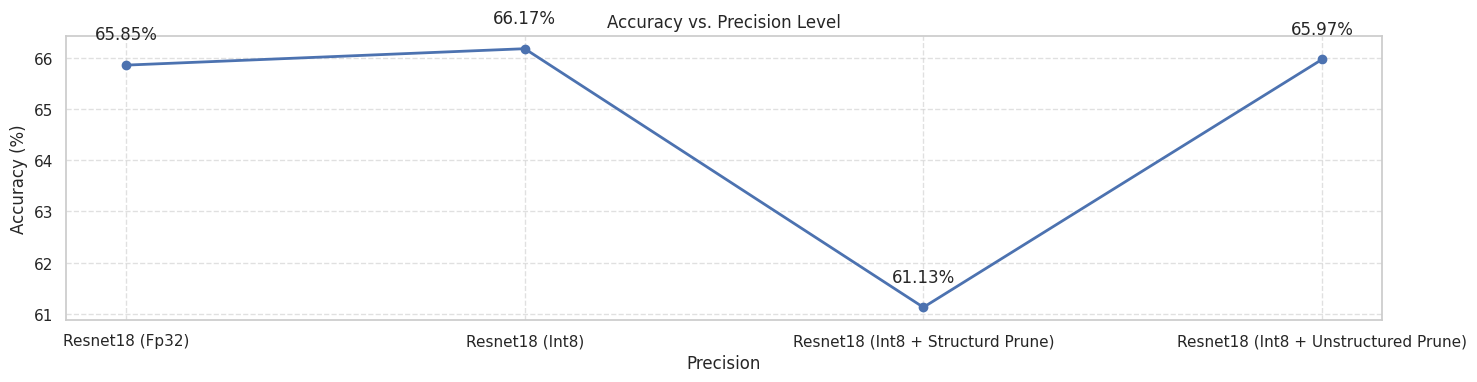

In [24]:
precisions = ['Resnet18 (Fp32)', 'Resnet18 (Int8)', 'Resnet18 (Int8 + Structurd Prune)', 'Resnet18 (Int8 + Unstructured Prune)']
plot_accuracy_vs_precision(precisions, accuracies)

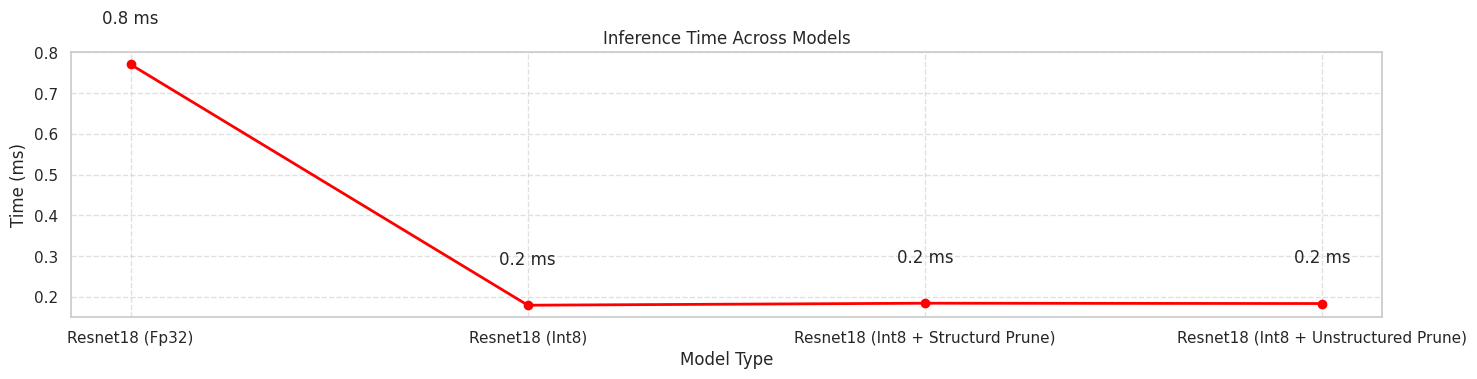

In [31]:
plot_inference_time(precisions, inf_speeds_quantization)

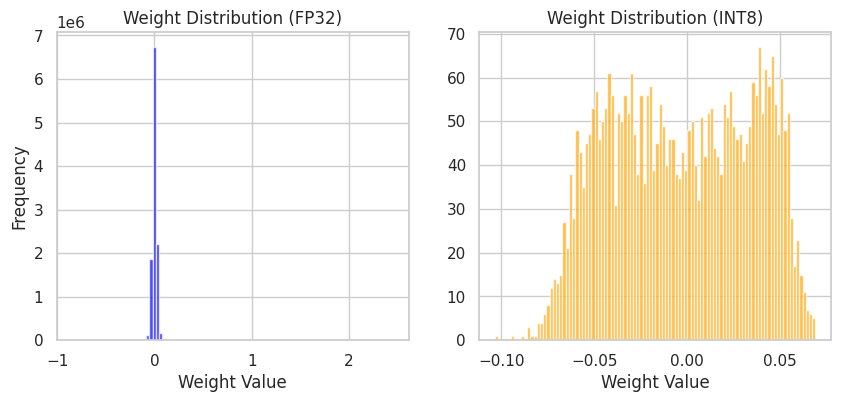

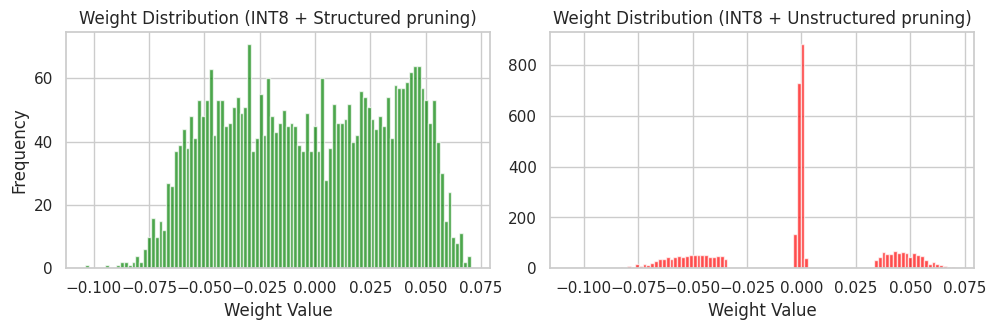

In [32]:
plot_quantized_weight_distribution(resnet18, resnet18_quant, resnet18_quant_pr_st, resnet18_quant_pr_unst)